### CS182 project - Deliver ideas of CGCNN

### General Explanation

The key idea of CGCNN is to represent crystal structure by a crystal graph, which encodes not only
the atomic information but also bonding information between atoms based on the distance. Here we
will let each atomic feature vector as vi, which encodes the property of the atom corresponding to
node i. The edge feature vector is represented as u(i,j)k, which encodes k-th bond connecting atom
i, j. Note that there can be several bonds between atoms, which originate from the periodic nature of
crystals. <br />
Obviously, there are many ways to encode atomic and bond data. For the sake of simplicity, we will
follow the methods used in the CGCNN paper, which used a pre-defined encoding vector to change
atoms into vectors. These vectors have 92 dimensions, and for 100 atoms in the periodic table, they
have different encodings which consist of 0 and 1. For the edge feature vectors, there also can be
many ways to encode bond information; bond length, angle, and covalency. However, we will only
use bond-length information between nearest neighbors, by applying a Gaussian kernel to change
it to encoding vectors. One can follow the homework notebook on how this embedding is done to
NaCl(salt) Crystal.

### Encoding Crystal into Crystal Graph

In [14]:
# Note: Need pymatgen

In [ ]:
!pip install pymatgen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.0/515.0 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 kB 43.1 MB/s eta 0:00:00


In [4]:
import os
import sys
import csv
import json
import torch
import torch.nn as nn
import random
import warnings
warnings.filterwarnings('ignore')
import functools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba_array

from pymatgen.core.structure import Structure
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.analysis.local_env import CrystalNN
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

from data_utils import CIFData
from data_utils import AtomCustomJSONInitializer
from data_utils import AtomInitializer
from data_utils import GaussianDistance

In [ ]:
!unzip cgcnn_data.zip
!unzip hw_data.zip

Let's convert salt (NaCl) to crystal graph. <br />
You can use print method to see the lattice and position of Na, Cl atoms in the cell. <br />
We will also visualize it to a graph. Each node of graph is atom in the crystal, and edge is bonds that have distance as information. 

In [5]:
# Load structure from CIF file 
nacl = Structure.from_file('hw_data/sample_regression/1000041.cif')
print(nacl)

Full Formula (Na4 Cl4)
Reduced Formula: NaCl
abc   :   5.620000   5.620000   5.620000
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (8)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Na+   0    0    0
  1  Na+   0    0.5  0.5
  2  Na+   0.5  0    0.5
  3  Na+   0.5  0.5  0
  4  Cl-   0.5  0.5  0.5
  5  Cl-   0.5  0    0
  6  Cl-   0    0.5  0
  7  Cl-   0    0    0.5


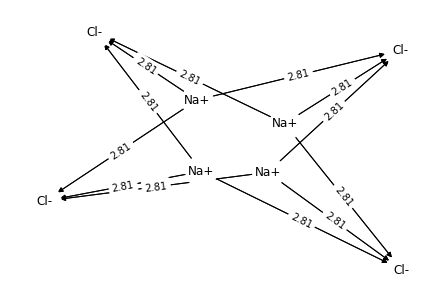

In [7]:
# Visualization of the structure using the CIF file 
crystal = CrystalNN()

sg = StructureGraph.with_local_env_strategy(nacl, crystal)

node_labels = {}
for i, site in enumerate(nacl):
    label = "{}".format(site.specie)
    node_labels[i] = label

edge_weights = {}
for edge in sg.graph.edges():
    dist = nacl.get_distance(edge[0], edge[1])
    edge_weights[edge] = dist

pos = nx.spring_layout(sg.graph)
nx.draw(sg.graph, pos, with_labels=True, labels=node_labels, font_size=12, node_size=1000, node_color="w")
nx.draw_networkx_edge_labels(sg.graph, pos, edge_labels=edge_weights, font_size=10)
plt.axis("off")
plt.show()

Next we will encode atoms in the node to atomistic feature vectors using pre-difined atom embedding. <br />
atom_init.json is containing vector embedding of atoms, where key (1, 2, 3, ..., 100) represent atomic number
and values are encoding vectors. <br />
You can try different atom embedding too if you want.

In [8]:
# Load embedding file.
element_embedding_file = 'hw_data/sample_regression/atom_init.json'
with open(element_embedding_file) as f:
    elem_embedding = json.load(f)
elem_embedding = {int(key): value for key, value
                  in elem_embedding.items()}

atom_fea = None
############################################################################
# TODO: Encode crsytal data to atomistic features. (Hint: Use np.vstack and 
# elem_embedding to join all embedded specie numbers of NaCl)
# Atom_feature shd have shape of (# of atoms, len(embedding vector))

# YOUR CODE HERE

############################################################################
assert atom_fea is not None
atom_fea = torch.Tensor(atom_fea)


assert atom_fea.shape == (8,92)

Next, we will get neighbor information from each atoms in the cell.
We will get help from pymatgen package.
get_all_neighbor function of structure object returns atoms within
the input radius. Note that here len(all_nbrs) is 8 since there are
8 atoms (4 Na+, 4 Cl-) in the cell. Each list contain the neighbor
atom information considering periodicity.
We will use 12 nearest neighbors after sorting with distance.

In [10]:
all_nbrs = nacl.get_all_neighbors(r = 8, include_index=True)
all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]

assert len(all_nbrs) == 8

nbr_fea_idx, nbr_fea = [], []
for nbr in all_nbrs:
    # Note: x[1] returns distance to neighbors.
    # Note: x[2] returns index of original structure object
    nbr_fea_idx.append(list(map(lambda x: x[2],
                                nbr[:12])))
    nbr_fea.append(list(map(lambda x: x[1],
                            nbr[:12])))

# nbr_fea_idx contain information of nearest neighbor atoms 
# from ith row (ith atom in the cell)
# For example, 0th atom (Na+ (0.0000, 0.0000, 0.0000)) is neighbored
# with 5th, 6th, 7th, etc...
# nbr_fea contain information of nearest neighbot distance. 
nbr_fea_idx, nbr_fea = np.array(nbr_fea_idx), np.array(nbr_fea)
nbr_fea_idx = torch.LongTensor(nbr_fea_idx)

nbr_fea_idx_standard = torch.LongTensor([[5, 6, 7, 7, 6, 5, 2, 1, 2, 1, 3, 3],
                                         [4, 7, 6, 7, 6, 4, 2, 0, 3, 2, 3, 3],
                                         [4, 7, 5, 7, 5, 4, 0, 3, 1, 3, 3, 1],
                                         [4, 6, 5, 6, 5, 4, 2, 1, 1, 2, 0, 0],
                                         [3, 1, 2, 3, 2, 1, 6, 5, 6, 5, 7, 7],
                                         [2, 3, 0, 3, 0, 2, 4, 4, 6, 6, 4, 7],
                                         [1, 3, 0, 3, 0, 1, 4, 4, 5, 5, 5, 4],
                                         [2, 1, 0, 2, 1, 0, 4, 5, 5, 4, 6, 6]])

assert torch.equal(nbr_fea_idx, nbr_fea_idx_standard)

Now we have two features, atomic feature and neighbor feature.
Note that neighbor feature is discontionous information with respect to the distance.
Therefore we will expand neighbor feature using Gaussian Kernel (or Gaussian filter)
https://en.wikipedia.org/wiki/Gaussian_filter

In [11]:
dmin = 0
dmax = 12
step = 0.2
var = step
filter_step = np.arange(dmin, dmax+step, step)

def expand(distances):
    ############################################################################
    # TODO: Implement the expand function using a Gaussian kernel.
    raise NotImplementedError()
    ############################################################################

    
nbr_fea_gaussian = expand(nbr_fea)

In [13]:
# assert np.array_equal(nbr_fea_gaussian, nbr_fea)

In [103]:
gdf = GaussianDistance(dmin=0, dmax=12, step=0.2)
nbr_fea = gdf.expand(nbr_fea)

In [25]:
# For testing
data_dir = './cgcnn_data/sample-regression'
test = CIFData(data_dir)
(atom_fea, nbr_fea, nbr_fea_idx), target, cif_id = test[-1]

In [26]:
# For testing
structures, _, _ = test[-1]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

### Build a Model

After building the crystal graph, the convolutional neural network act on top of the graph, and
consecutive fully connected networks and pooling layer are used to predict the property of crystals.
The convolution layer iteratively updates the atom feature vector $v_{i}$ by message passing with
surrounding atoms and bonds with a non-linear graph convolution function:

$ v_{i}^{(t+1)} = Conv(v_{i}^{(t)}, v_{j}^{(t)}, u_{(i,j)_{k}}), (i,j)_{k} \in G $

And then consequetive pooling layer and hidden fully connected layer will generate output of model:

$ v_{c} = Pool(v_{0}^{(0)}, v_{1}^{(0)}, ..., v_{N}^{(0)}, ..., v_{N}^{(R)}) $

Note that we can use any Convolution and Pooling layer if we maintain the permutation invariance. Here we will try two different convolution layer. Try to implement following two layers in the TODO section of model_hw.py. Note that we will do not change pooling layer, and you can use any activation function you use.

1. Convolution weight matrix is shared by all neighbors. <br />
$ v_{i}^{(t+1)} = g[(\sum_{j,k}v_{j}^{(t)} \oplus u_{(i,j)_{k}})W_{c}^{(t)}+v_{i}^{(t)}W_{s}^{(t)}+b^{(t)}] $

2. Convolution weight matrix is differentiated at all neighbor pairs. <br />
$ v_{i}^{(t+1)} = v_{i}^{(t+1)} + \sum_{j,k}\sigma(z_{(i,j)_{k}}^{(t)}W_{f}^{(t)}+b_{f}^{(t)}) \odot g(z_{(i,j)_{k}}^{(t)}W_{s}^{(t)}+b_{s}^{(t)}) $

In [15]:
from model import CrystalGraphConvNet

In [34]:
# Simple test
# Set seed using manual_seed
# TODO explanation about crystal_atom_idx
torch.manual_seed(123)
crystal_atom_idx = [torch.Tensor([0, 1, 2, 3, 4, 5, 6, 7]).long()]
############################################################################
# TODO: Implement the CrystalGraphConvNet model in model_hw.py
############################################################################

model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len)
out = model.forward(atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)
assert out.item() == 0.6627039313316345

### Training

If you built a model, let's train and visualize it. What is the difference between two models? Which one performs better and why do you think so? <br />
Based on what you observed, can you make a convolution layer that performs better?

In [109]:
from data_utils import collate_pool, get_train_val_test_loader
from train_utils import Normalizer, train, validate, save_checkpoint
from model import CrystalGraphConvNet
from random import sample

In [110]:
torch.manual_seed(123)

# set parameters
data_dir = './hw_data/perovskite_energy'
batch_size = 8
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1

# get dataset

dataset = CIFData(data_dir)
collate_fn = collate_pool
train_loader, val_loader, test_loader = get_train_val_test_loader(
    dataset=dataset,
    collate_fn=collate_fn,
    batch_size=batch_size,
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    test_ratio=test_ratio,
    return_test=True)

In [111]:
# normalize target

if len(dataset) < 500:
    warnings.warn('Dataset has less than 500 data points. '
                    'Lower accuracy is expected. ')
    sample_data_list = [dataset[i] for i in range(len(dataset))]
else:
    sample_data_list = [dataset[i] for i in
                        sample(range(len(dataset)), 500)]
_, sample_target, _ = collate_pool(sample_data_list)
normalizer = Normalizer(sample_target)

In [112]:
# build model
structures, _, _ = dataset[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]
############################################################################
# TODO: Tune the following parameters to optimize performance.
############################################################################
# number of hidden atom features in conv layers
atom_fea_len = 64
# number of hidden features after pooling
h_fea_len = 128
# number of conv layers
n_conv = 3
# number of hidden layers after pooling
n_h = 1

model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len,
                            atom_fea_len=atom_fea_len,
                            n_conv=n_conv,
                            h_fea_len=h_fea_len,
                            n_h=n_h)

In [115]:
# set hyperparameters
epochs = 15
criterion = nn.MSELoss()
lr = 0.01
momentum = 0.9
weight_decay = 0

optimizer = optim.SGD(model.parameters(), lr,
                              momentum=momentum,
                              weight_decay=weight_decay)

# optimizer = optim.Adam(model.parameters(), lr,
#                         weight_decay=weight_decay)
lr_milestones = [100]
scheduler = MultiStepLR(optimizer, milestones=lr_milestones,
                            gamma=0.1)

In [ ]:
running_record = {'train_loss': [], 'train_mae': [],
                    'val_loss': [], 'val_mae': []}

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 10)
    
    best_mae_error = 1e10
    # train for one epoch
    train_loss, train_mae = train(train_loader, model, criterion, optimizer, epoch, normalizer)

    # evaluate on validation set
    val_loss, val_mae = validate(val_loader, model, criterion, normalizer)

    # append loss and mae to running record. Convert tensor to float if necessary
    running_record['train_loss'].append(train_loss)
    running_record['train_mae'].append(train_mae)
    running_record['val_loss'].append(val_loss)
    running_record['val_mae'].append(val_mae)


    if val_mae != val_mae:
        print('Exit due to NaN')
        sys.exit(1)

    scheduler.step()

    # remember the best mae_eror and save checkpoint
    is_best = val_mae < best_mae_error
    best_mae_error = min(val_mae, best_mae_error)

    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_mae_error': best_mae_error,
        'optimizer': optimizer.state_dict(),
        'normalizer': normalizer.state_dict(),
    }, is_best)


In [117]:
# test best model
print('---------Evaluate Model on Test Set---------------')
best_checkpoint = torch.load('model_best.pth.tar')
model.load_state_dict(best_checkpoint['state_dict'])
_, l=validate(test_loader, model, criterion, normalizer, test=True)

---------Evaluate Model on Test Set---------------
Test: [0/9]	Time 0.173 (0.173)	Loss 2.0494 (2.0494)	MAE 66.022 (66.022)
 ** MAE 48.115


tensor(48.1149)

In [ ]:
# visualize the training and val loss 
# visualize the training and val mae
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].plot(running_record['train_loss'], label='train')
ax[0].plot(running_record['val_loss'], label='val')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Loss')
# set x axis to be integer
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[1].plot(running_record['train_mae'], label='train')
ax[1].plot(running_record['val_mae'], label='val')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MAE')
ax[1].legend()
ax[1].set_title('MAE')
# set x axis to be integer
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()